In [1]:
!nvidia-smi

Sat Nov  6 08:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   66C    P0   293W / 300W |  32247MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from glob import glob

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
#     CLASSES = ['RightFemur', 'LeftFemur', 'RightHip', 'LeftHip', 'Sacrum']
    CLASSES = ['RightFemur', 'LeftFemur', 'RightHip', 'LeftHip', 'Sacrum']
    
    def __init__(
            self,
            csv_path,
            images_dir, 
            masks_dir,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            mode='train'
    ):
        self.mode = mode
        if self.mode != 'xray':
            self.csv = pd.read_csv(csv_path).values
            pos = self.csv[:, -1] == self.mode
            self.csv = self.csv[pos]
            self.imgs_lst = [os.path.join(images_dir, f"{x}_drr.png") for x in self.csv[:, 0]]
            self.masks_lst = [os.path.join(masks_dir, f"{x}_mask.png") for x in self.csv[:, 0]]

            # convert str names to class values on masks
            self.class_values = [self.CLASSES.index(cls) for cls in classes]
        else:
            self.imgs_lst = glob(f"{images_dir}/*png")
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read data
        if self.mode != 'xray':
            image = np.array(Image.open(self.imgs_lst[idx]).convert("RGB"))
            masks = [self.masks_lst[idx].replace("_mask", f"_{x}") for x in range(1, len(self.class_values)+1)]
            masks = [np.array(Image.open(x).convert("L")) for x in masks]
            # background
    #         foreground = np.stack(masks, axis=-1).astype('float')
    #         background = np.sum(foreground, axis=2) != 255
    #         masks += [background*255]

            # extract certain classes from mask (e.g. cars)
            mask = np.stack(masks, axis=-1).astype('float')
            mask = np.where(mask==255, 1, 0)
        else:
            image = np.array(Image.open(self.imgs_lst[idx]).convert("RGB"))
            mask = np.zeros(image.shape)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.imgs_lst)

In [5]:
csv_path = "/home/ctpel/ctpel_split.csv"
img_dir = "/home/ctpel/ctpel_drr/drr"
mask_dir = "/home/ctpel/ctpel_drr/mask"

In [6]:
# Lets look at data we have

dataset = Dataset(csv_path,
                  img_dir,
                  mask_dir,
                  classes=['RightFemur', 'LeftFemur'])

image, mask = dataset[0] # get some sample

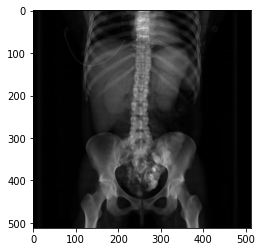

In [7]:
plt.imshow(image)

In [8]:
np.max(mask[:, :, 0])

1

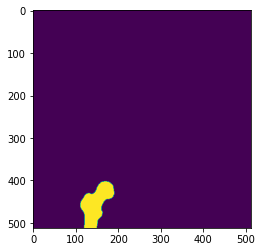

In [9]:
plt.imshow(mask[:, :, 0])

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

#         albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.05, rotate_limit=0.05, shift_limit=0.05, p=0.5, border_mode=0),

        albu.augmentations.transforms.GaussNoise(p=0.2),
        albu.augmentations.geometric.transforms.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.augmentations.transforms.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [12]:
# Lets look at data we have

augmented_dataset = Dataset("/home/ctpel/ctpel_split.csv", 
                  "/home/ctpel/ctpel_drr/drr",
                  "/home/ctpel/ctpel_drr/mask",
                  augmentation=get_training_augmentation(), 
                  classes=['RightFemur', 'LeftFemur', 'RightHip', 'LeftHip', 'Sacrum'])

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1772: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


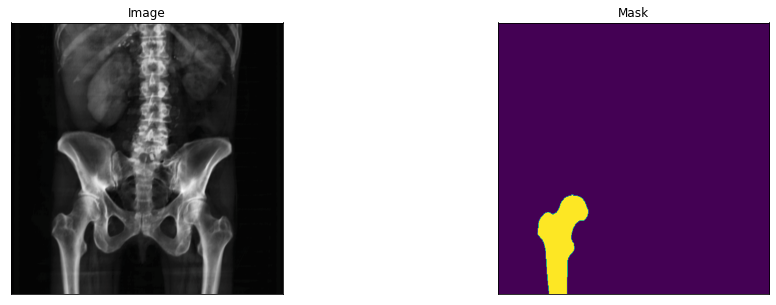

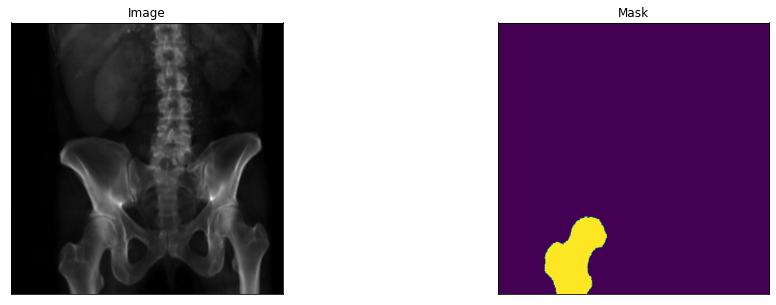

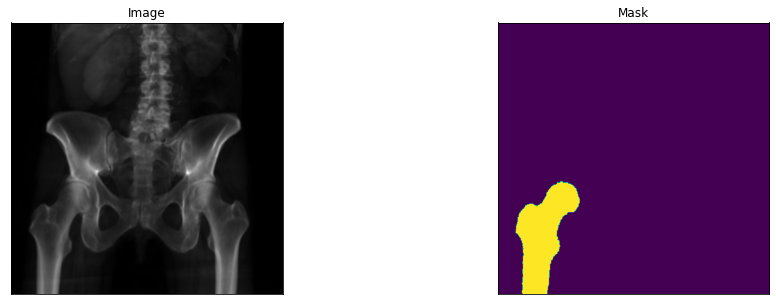

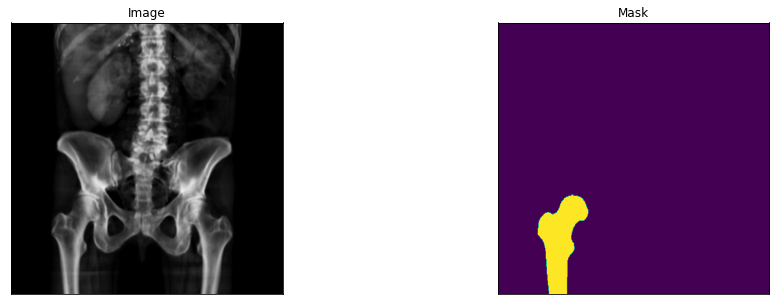

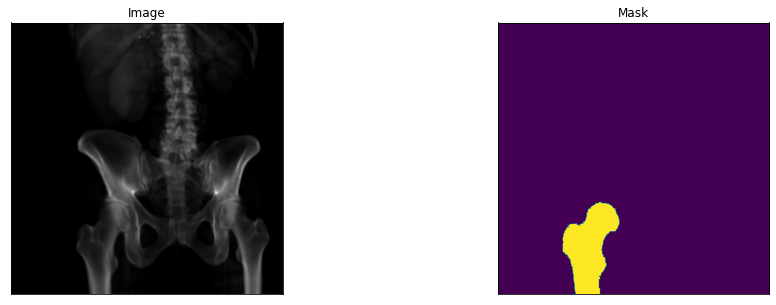

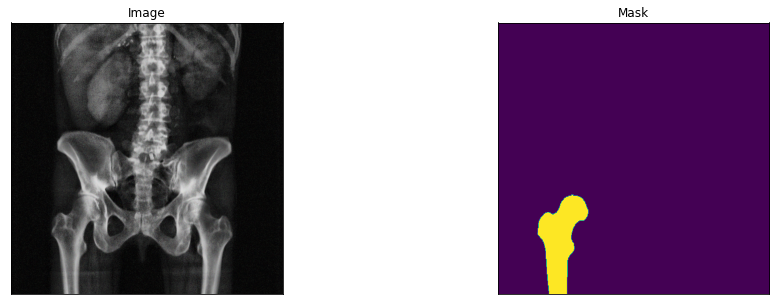

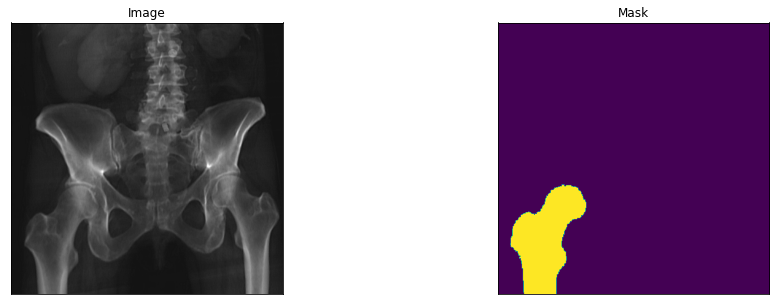

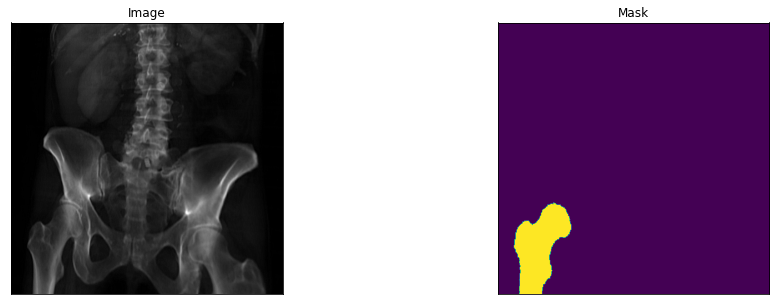

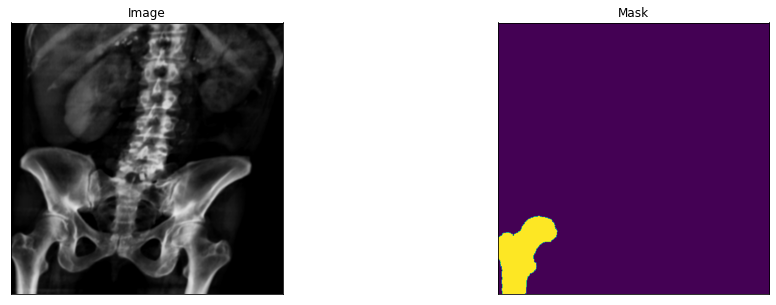

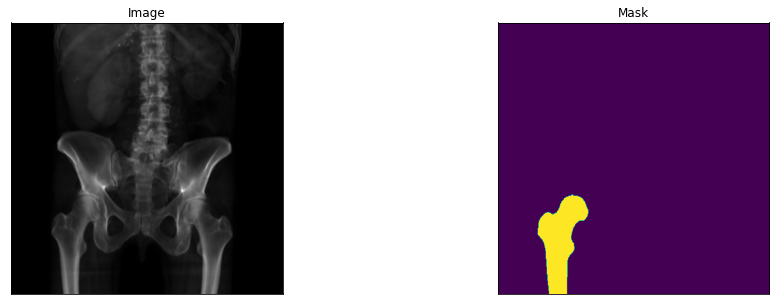

In [13]:
for i in range(10):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask[:, :, 0])

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['RightFemur', 'LeftFemur', 'RightHip', 'LeftHip', 'Sacrum']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
train_dataset = Dataset(
    csv_path,
    img_dir, 
    mask_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mode= 'train'
)

valid_dataset = Dataset(
    csv_path,
    img_dir, 
    mask_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mode= 'val'
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [18]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.005),
])

In [19]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [20]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_bone.pth')
        print('Model saved!')
        
    if i == 50:
        optimizer.param_groups[0]['lr'] = 5e-4
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:00<00:00, 12.58it/s, dice_loss - 0.8431, iou_score - 0.08741, fscore - 0.1587]
Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s, dice_loss - 0.8804, iou_score - 0.06085, fscore - 0.114] 

Epoch: 2
valid: 100%|██████████| 10/10 [00:00<00:00, 12.89it/s, dice_loss - 0.9147, iou_score - 0.0443, fscore - 0.08453]

Epoch: 3
valid: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s, dice_loss - 0.8402, iou_score - 0.09813, fscore - 0.1776]
Model saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s, dice_loss - 0.5592, iou_score - 0.3248, fscore - 0.4878]
Model saved!

Epoch: 5
valid: 100%|██████████| 10/10 [00:00<00:00, 12.56it/s, dice_loss - 0.4236, iou_score - 0.4396, fscore - 0.6067]
Model saved!

Epoch: 6
valid: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s, dice_loss - 0.6621, iou_score - 0.2124, fscore - 0.3441]

Epoch: 7
valid: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s, dice_loss - 0.6466, iou_s

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model_bone.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    csv_path,
    img_dir, 
    mask_dir,  
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mode= 'test'
)

test_dataloader = DataLoader(test_dataset)

In [29]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, dice_loss - 0.02267, iou_score - 0.9581, fscore - 0.9786]


In [23]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    csv_path,
    img_dir, 
    mask_dir,  
    classes=CLASSES,
    mode= 'test'
)

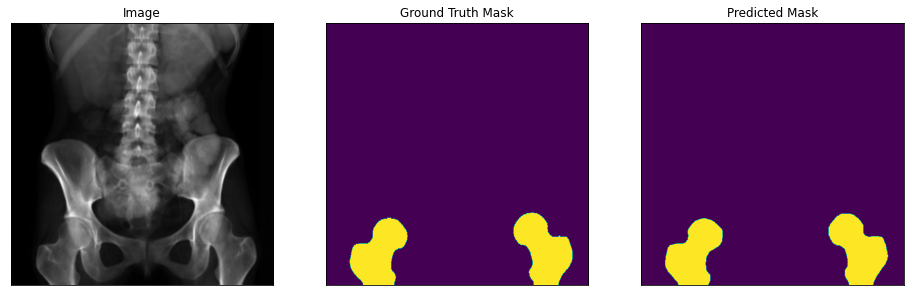

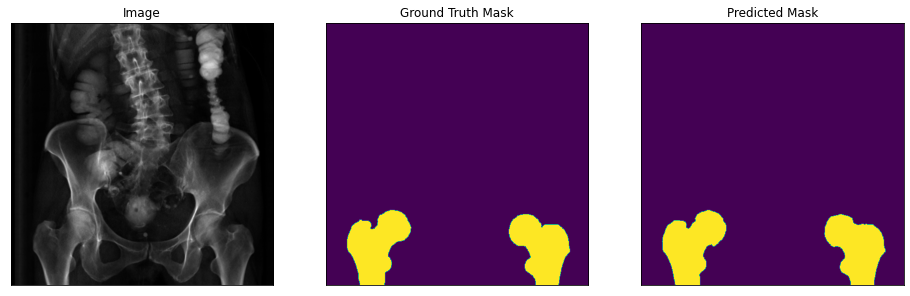

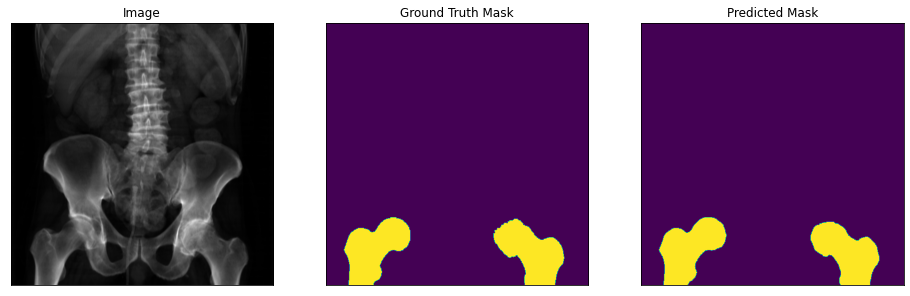

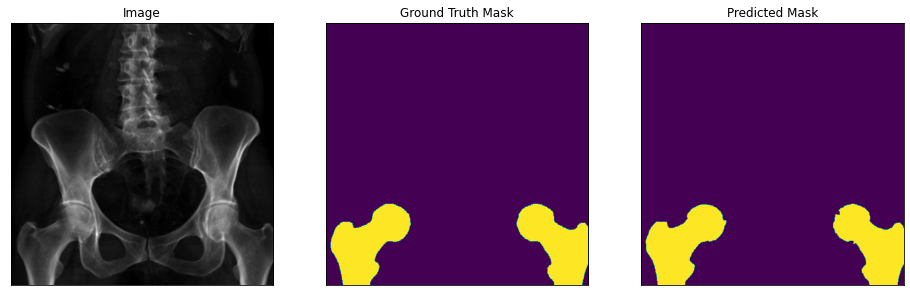

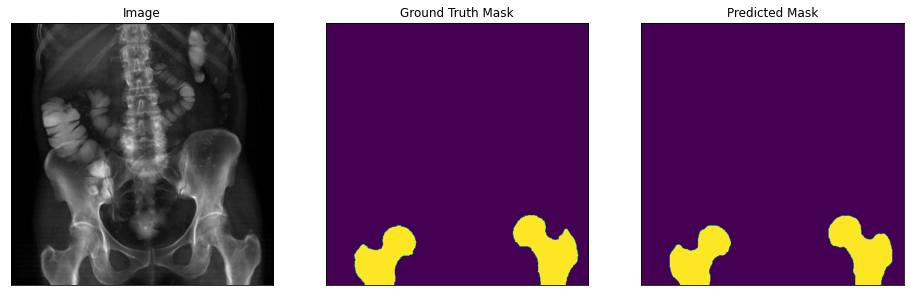

In [31]:
for i in range(5):
    n = i
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[0]+gt_mask[1], 
        predicted_mask=pr_mask[0]+pr_mask[1]
    )

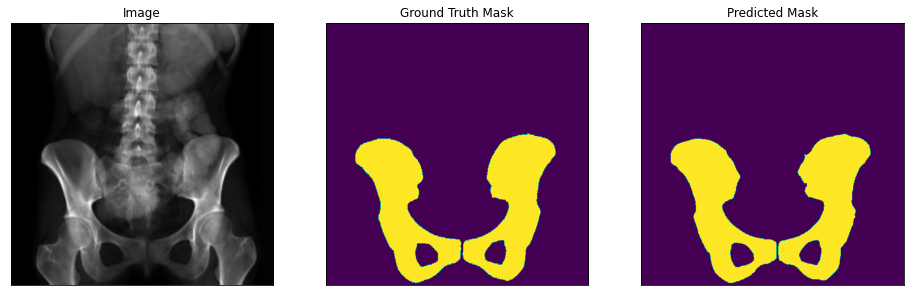

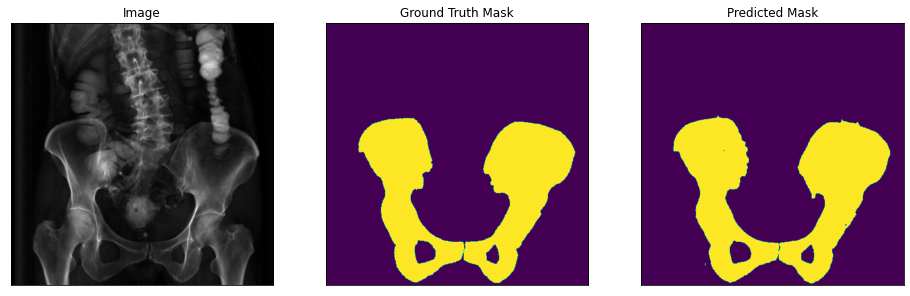

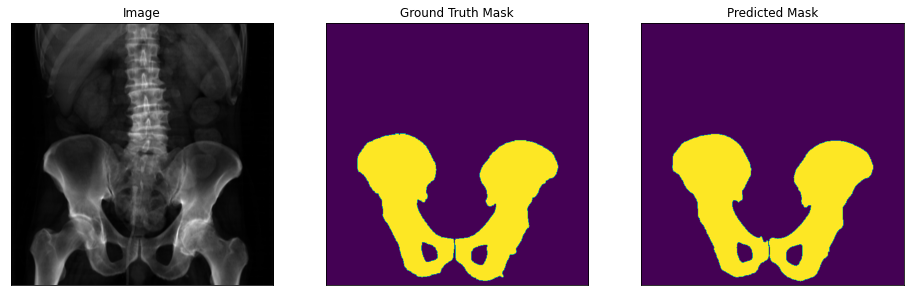

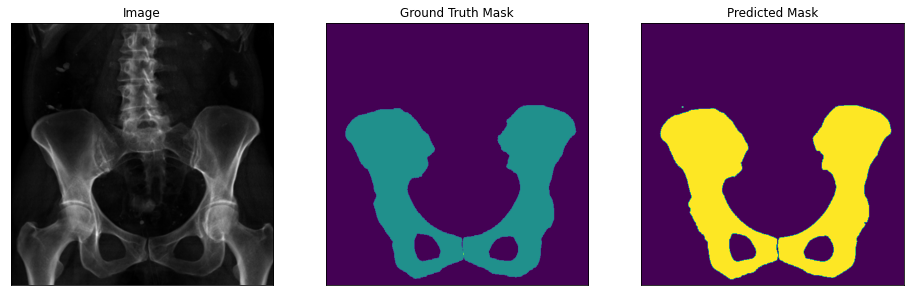

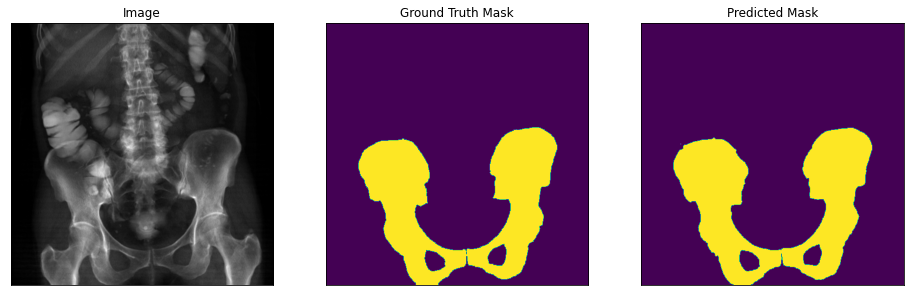

In [32]:
for i in range(5):
    n = i
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[2]+gt_mask[3], 
        predicted_mask=pr_mask[2]+pr_mask[3]
    )

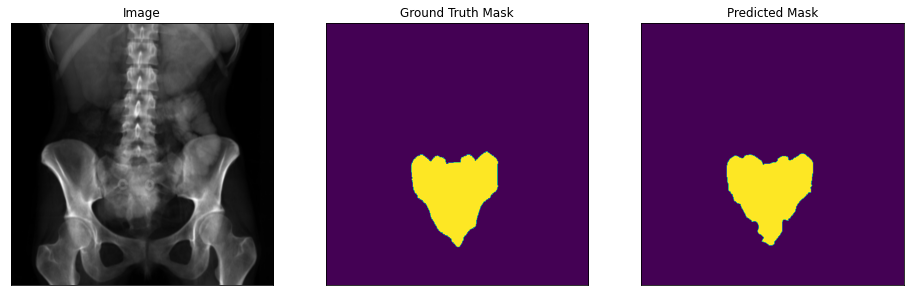

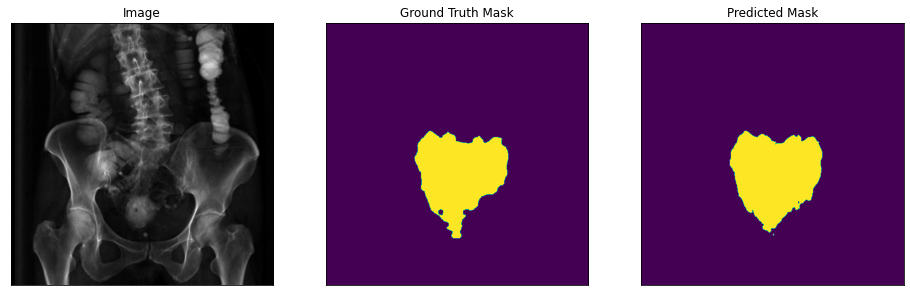

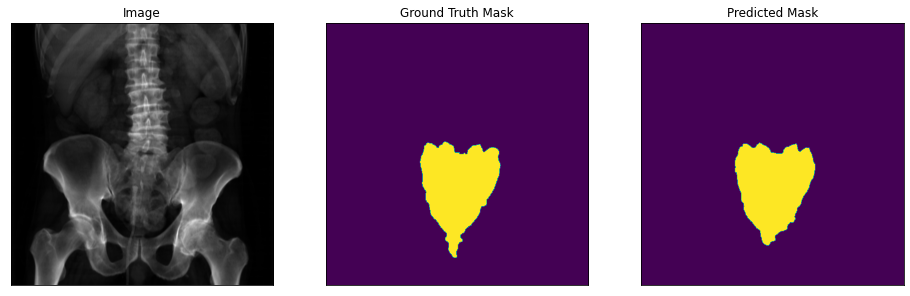

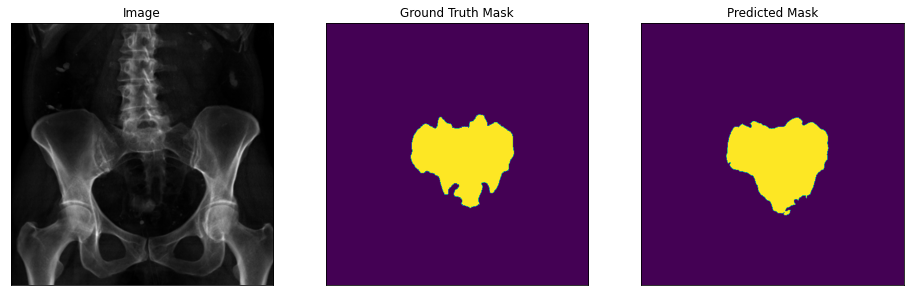

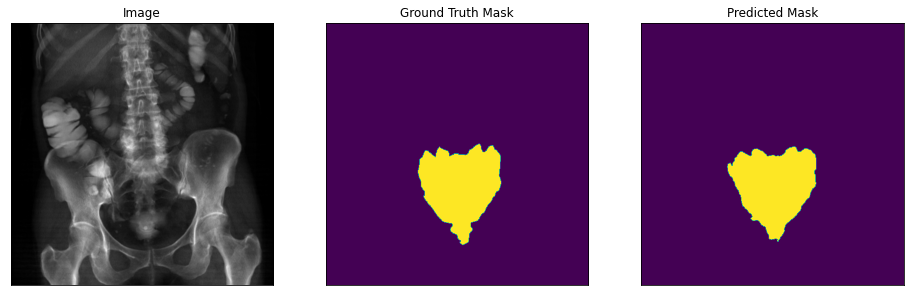

In [33]:
for i in range(5):
    n = i
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[4], 
        predicted_mask=pr_mask[4]
    )

In [37]:
test_dataset.imgs_lst

['/home/ctpel/ctpel_drr/drr/083B371B51E8CC0B_drr.png',
 '/home/ctpel/ctpel_drr/drr/186C2C2E731D073F_drr.png',
 '/home/ctpel/ctpel_drr/drr/623800C4D6E06CFF_drr.png',
 '/home/ctpel/ctpel_drr/drr/7D8E6E1C05D04B9D_drr.png',
 '/home/ctpel/ctpel_drr/drr/A09CBBD45477851D_drr.png',
 '/home/ctpel/ctpel_drr/drr/B16E560C37DE59B8_drr.png',
 '/home/ctpel/ctpel_drr/drr/B4DE93C52883978B_drr.png',
 '/home/ctpel/ctpel_drr/drr/B9E075DD7DC4993D_drr.png',
 '/home/ctpel/ctpel_drr/drr/FD8E42D075A45A2F_drr.png',
 '/home/ctpel/ctpel_drr/drr/D8807180F5048ADF_drr.png']

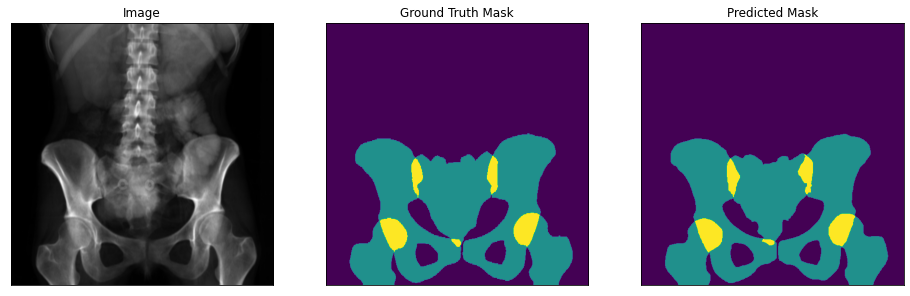

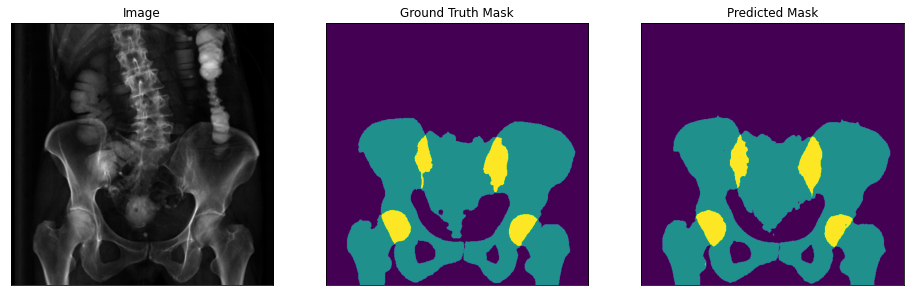

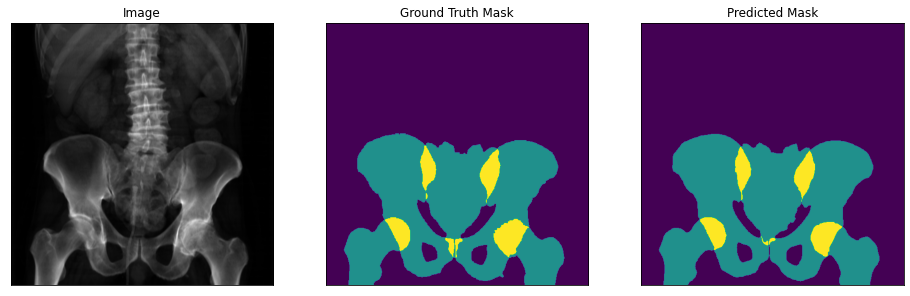

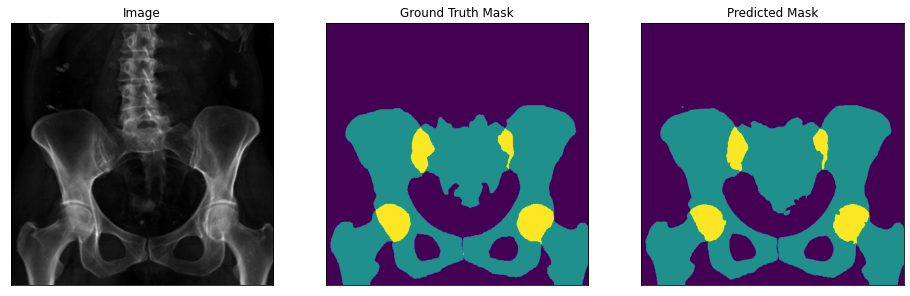

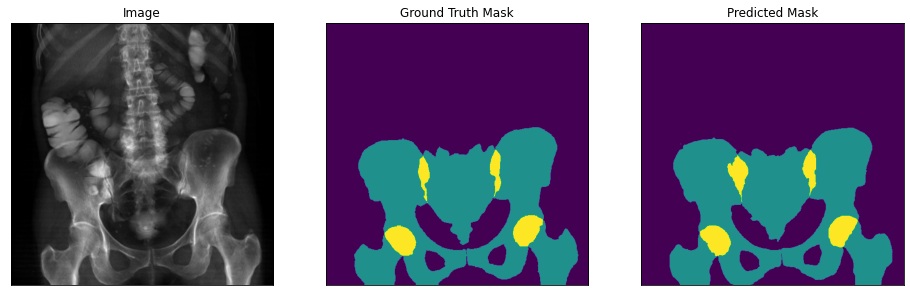

In [34]:
for i in range(5):
    n = i
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=np.sum(gt_mask, axis=0), 
        predicted_mask=np.sum(pr_mask, axis=0)
    )

In [63]:
# create test dataset
xray_dataset = Dataset(
    csv_path,
    "xray", 
    mask_dir,  
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mode= 'xray'
)

xray_dataloader = DataLoader(xray_dataset)

In [64]:
image, gt_mask = xray_dataset[0]


x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

In [399]:
len(xray_dataset)

1

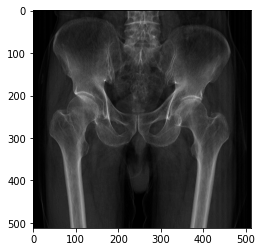

In [65]:
plt.imshow(image[0], cmap='gray')

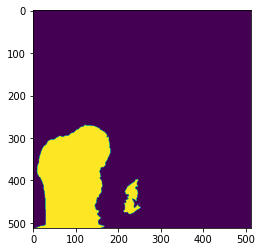

In [408]:
plt.imshow(pr_mask[0])

In [66]:
image, gt_mask = test_dataset[0]


x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

In [67]:
RGBforLabel = {0:(0,0,255), 
               1:(0,255,0), 
               2:(255,0,0),
               3:(255,0,255),
               4:(255,255,0)}

# Blue -  Right Femur  
# Green - Left Femur  
# Red - Right Hip 
# Purple -  Left Hip
# Yellow - Sacrum

In [68]:
img_dict = dict()
for i in range (5):
    img_dict[i]=np.array(pr_mask[i]*255).astype(np.uint8)

In [69]:
import cv2

In [70]:
drr_arr = cv2.imread(xray_dataset.imgs_lst[0])

In [71]:
for i in RGBforLabel:
    contours, _ = cv2.findContours(img_dict[i], cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        label = int(i)
        colour = RGBforLabel.get(label)
        cv2.drawContours(drr_arr,[c],-1,colour,3)

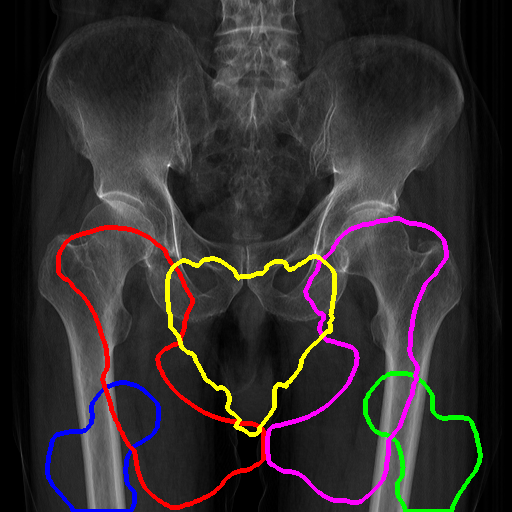

In [72]:
Image.fromarray(drr_arr)

In [97]:
# create test dataset
hipct_dataset = Dataset(
    csv_path,
    "xray", 
    mask_dir,  
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    mode= 'xray'
)

hipct_dataloader = DataLoader(hipct_dataset)

In [112]:
th = 0.99
image, gt_mask = hipct_dataset[3]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy() > th)

In [113]:
RGBforLabel = {0:(0,0,255), 
               1:(0,255,0), 
               2:(255,0,0),
               3:(255,0,255),
               4:(255,255,0)}

# Blue -  Right Femur  
# Green - Left Femur  
# Red - Right Hip 
# Purple -  Left Hip
# Yellow - Sacrum

In [114]:
img_dict = dict()
for i in range (5):
    img_dict[i]=np.array(pr_mask[i]*255).astype(np.uint8)

In [115]:
import cv2

In [123]:
drr_arr = cv2.imread(hipct_dataset.imgs_lst[0])

In [117]:
for i in RGBforLabel:
    contours, _ = cv2.findContours(img_dict[i], cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        label = int(i)
        colour = RGBforLabel.get(label)
        cv2.drawContours(drr_arr,[c],-1,colour,3)

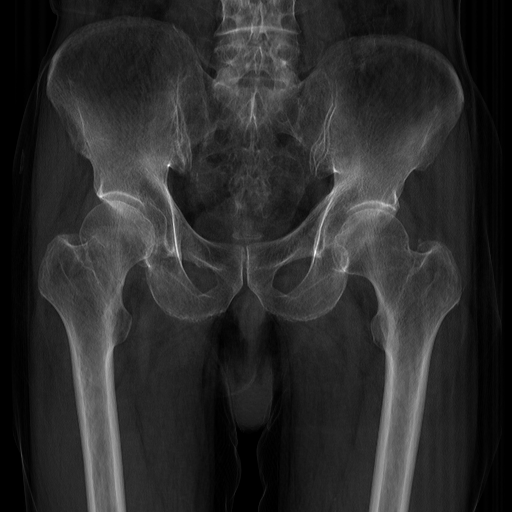

In [124]:
Image.fromarray(drr_arr)